<a href="https://colab.research.google.com/github/indra622/AIAcademy_SpeechRecognition/blob/main/Multi_AI_Agent_Study/Part3_Ch3_04_supervision_multi_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q langchain langchain-openai langgraph python-dotenv langchain-community langchain-experimental yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.9/130.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.9 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)
python_repl_tool = PythonREPLTool()

In [4]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd

ticker = yf.Ticker("NVDA")
historical_prices = ticker.history(period='5d', interval='1d')

last_5_days_close = historical_prices['Close'].tail(5)
last_5_days_close_dict = {date.strftime('%Y-%m-%d'): price for date, price in last_5_days_close.items()}
# 연간 및 분기별 재무제표 데이터 가져오기
last_5_days_close_dict

{'2025-02-24': 130.27999877929688,
 '2025-02-25': 126.62999725341797,
 '2025-02-26': 131.27999877929688,
 '2025-02-27': 120.1500015258789,
 '2025-02-28': 124.91999816894531}

In [5]:
from langchain.tools import BaseTool, StructuredTool, tool
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd

#재무 분석 툴 설정
@tool
def stock_analysis(ticker: str) -> str:
    """
    주어진 주식 티커에 대한 업데이트된 종합적인 재무 분석을 수행합니다.
    최신 주가 정보, 재무 지표, 성장률, 밸류에이션 및 주요 비율을 제공합니다.
    가장 최근 영업일 기준의 데이터를 사용합니다.

    :param ticker: 분석할 주식의 티커 심볼
    :return: 재무 분석 결과를 포함한 문자열
    """
    def format_number(number):
        if number is None or pd.isna(number):
            return "N/A"
        return f"{number:,.0f}"

    def format_financial_summary(financials):
        summary = {}
        for date, data in financials.items():
            date_str = date.strftime('%Y-%m-%d')
            summary[date_str] = {
                "총수익": format_number(data.get('TotalRevenue')),
                "영업이익": format_number(data.get('OperatingIncome')),
                "순이익": format_number(data.get('NetIncome')),
                "EBITDA": format_number(data.get('EBITDA')),
                "EPS(희석)": f"${data.get('DilutedEPS'):.2f}" if pd.notna(data.get('DilutedEPS')) else "N/A"
            }
        return summary

    ticker = yf.Ticker(ticker)
    historical_prices = ticker.history(period='5d', interval='1d')

    last_5_days_close = historical_prices['Close'].tail(5)
    last_5_days_close_dict = {date.strftime('%Y-%m-%d'): price for date, price in last_5_days_close.items()}
    # 연간 및 분기별 재무제표 데이터 가져오기
    annual_financials = ticker.get_financials()
    quarterly_financials = ticker.get_financials(freq="quarterly")

    return str({
        "최근 5일간 종가": last_5_days_close_dict,
        "연간 재무제표 요약": format_financial_summary(annual_financials),
        "분기별 재무제표 요약": format_financial_summary(quarterly_financials),
    })

In [6]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal

members = ["Researcher", "Stock_Analyzer", "Chart_Generator"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members

class routeResponse(BaseModel):
    next: Literal[*options]

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


llm = ChatOpenAI(model="gpt-4o-mini")

def supervisor_agent(state):
    supervisor_chain = (
        prompt
        | llm.with_structured_output(routeResponse)
    )
    return supervisor_chain.invoke(state)

In [7]:
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}

In [8]:
import functools
import operator
from typing import Sequence, TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

research_system_prompt = """You are a helpful research analyst who is specialized in
gathering valuable info for given stock."""
research_agent = create_react_agent(llm, tools=[tavily_tool], state_modifier=research_system_prompt)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
stock_system_prompt="""You are a helpful Stock and financial analyst. Never hallucinate the given metrics."""
stock_agent = create_react_agent(llm, tools=[stock_analysis], state_modifier=stock_system_prompt)
stock_node = functools.partial(agent_node, agent=stock_agent, name="Stock_Analyzer")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
chart_system_prompt="""You are a helpful Stock Chart Generator.
Only make accurate charts for given query. Chart design and accuracy should be state of the art.
Never make any other mention."""
chart_agent = create_react_agent(llm, tools=[python_repl_tool], state_modifier=chart_system_prompt)
chart_node = functools.partial(agent_node, agent=chart_agent, name="Chart_Generator")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Stock_Analyzer", stock_node)
workflow.add_node("Chart_Generator", chart_node)
workflow.add_node("supervisor", supervisor_agent)

In [9]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    conditional_map)
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

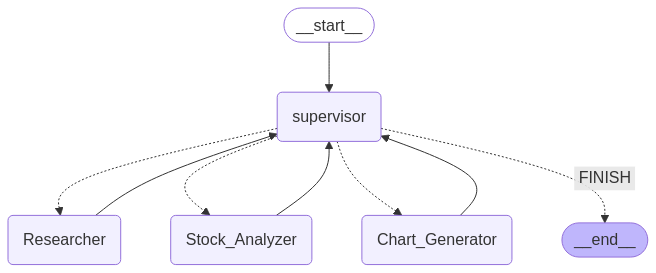

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='애플 주식(AAPL) 구매 결정을 위한 몇 가지 정보를 제공하겠습니다.\n\n1. **주가 동향**:\n   - 2023년 10월 31일 기준 애플의 주가는 $169.53로, 10월 한 달 간 0.3% 하락했습니다. 현재 주가는 $240.37입니다.\n   - 2023년 10월 13일에는 $177.55로 마감했으며, 하루 동안 1.4% 하락했음을 보여줍니다.\n\n2. **재무 성과**:\n   - 애플은 2023년에 22년 만에 가장 긴 수익 감소를 겪었습니다. 연속 4분기 동안 매출이 감소했으며, 새로운 제품 출시와 스마트폰 및 노트북에 대한 글로벌 수요 회복이 필요합니다.\n   - 아이폰은 여전히 애플의 가장 중요한 하드웨어 제품으로, 전체 매출의 약 절반을 차지합니다.\n\n3. **미래 전망**:\n   - UBS의 분석에 따르면, 애플의 새로운 헤드셋인 비전 프로(Vision Pro)가 약 1.4억 달러의 수익을 창출할 것으로 예상되고 있습니다.\n   - 애플은 현재 약 20억 대의 기기를 사용 중이며, 이는 향후 소프트웨어 및 서비스 매출 예측에 영향을 미치는 중요한 지표로 여겨집니다.\n\n4. **주가 변동**:\n   - 애플의 52주 최고가는 $260.10로 현재 주가 대비 약 5.9% 높은 수준이며, 52주 최저가는 $164.07로 현재 주가보다 33.2% 낮은 수준입니다.\n\n이러한 정보를 바탕으로 애플 주식 구매에 대한 결정을 고려해 보시기 바랍니다. 더 알고 싶으신 점이나 특정 질문이 있으시면 말씀해 주세요!', additional_kwargs={}, response_metadata={}, name='Researcher')]}}
----
{'supervisor': {'next': 'Stock_Analyzer'}}
----
{'Stock_Analyzer': {'m

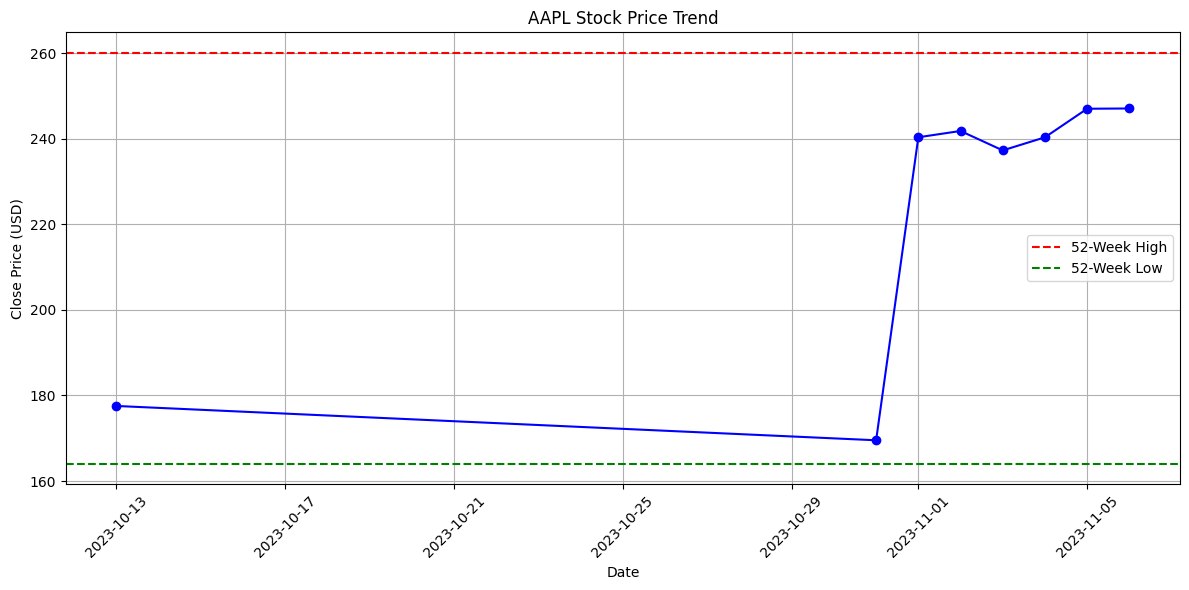

{'Chart_Generator': {'messages': [HumanMessage(content="Here is the stock price trend chart for Apple Inc. (AAPL):\n\n- **Current Price**: $240.37\n- **52-Week High**: $260.10 (shown as a red dashed line)\n- **52-Week Low**: $164.07 (shown as a green dashed line)\n\nThis chart visualizes the recent movements in AAPL's stock price, capturing variations over recent dates. \n\nPlease let me know if you have any other questions or need further analysis!", additional_kwargs={}, response_metadata={}, name='Chart_Generator')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [11]:
for s in graph.stream({"messages": [HumanMessage(content="애플 주식 구매 의사 결정 도와줘")]}):
    if "__end__" not in s:
        print(s)
        print("----")